# Red Wine Quality - Linear Regression Project

## Introduction

In this notebook, I explore the Portuguese "Vinho Verde" wine dataset to analyze the relationships between various wine characteristics. I apply linear regression to examine how certain quantitative features (such as sulphates, total sulfur dioxide, and volatile acidity) relate to one another and influence key measurements.

Additionally, I use logistic regression to study how these features may affect a categorical outcome, specifically the wine quality class. Through this analysis, I aim to understand both the continuous and categorical dependencies in the dataset and assess how different modeling approaches capture these relationships.

## Data Anlasys


In [16]:
# import libraries

import pandas as pd
import numpy as np
import sqlite3
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from ISLP.models import ModelSpec as MS, summarize, poly
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# read the csv file into a DataFrame
wine_df = pd.read_csv("winequality-red.csv")
wine_df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [18]:
# Describe the dataset. Understand and document clearly what each variable in the dataset measures.
wine_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

The variables of the dataset provide details about the following features:
- Fixed Acid: contributes to wine stability and crispness, high levels mean sharper taste. Typical range: ~4–15 g/L
- Volatile Acidity: low levels are acceptable and don't affect the odor. Typical range: ~0.1–1.5 g/L
- Citric Acid: enhances flavor and freshness, too little amount leads to flat wine. Typical range: ~0–1 g/L
- Residual sugar: affects sweetness. Dry wines have usually <4 g/L.Typical range: ~0.9–15 g/L
- Chlorides: high levels gives brackish or saline taste. Typical range: ~0.01–0.2 g/L
- Free Sulfur Dioxide: helps preserve wine, especially whites. Too much provokes pungent smell. Typical range: ~1–70 mg/L
- Total Sulfur Dioxide: it helps preservation but to high might cause headache. Typical range: ~10–350 mg/L (limit by law varies)
- Density: helps the alchol/sugar balance. Typical range ~0.990–1.004 g/cm³
- pH: inversely proportional to the acidity.
- Sulphates: additive used for preservation. Typical range ~0.3–1.5 g/L
- Alchol: Typical range ~12–15 °

In [19]:
# create a connection to the SQLite database
conn = sqlite3.connect(
    ":memory:"
)  # Use ":memory:" for temporary DB, or "your_db.db" to save
wine_df.to_sql("Wine", conn, if_exists="replace", index=False)

1599

In [20]:
query = "SELECT * FROM Wine LIMIT 10"
result = pd.read_sql_query(query, conn)
print(result)

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   
5            7.4              0.66         0.00             1.8      0.075   
6            7.9              0.60         0.06             1.6      0.069   
7            7.3              0.65         0.00             1.2      0.065   
8            7.8              0.58         0.02             2.0      0.073   
9            7.5              0.50         0.36             6.1      0.071   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0

In [21]:
# Describe how and when the data was collated, what is the sample size, and any other important detail.
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


The data have been collected in 2009, from Cortez et al, in relation to the study of various sample from the Portuguese wine Vihno Verde.

The dataset contains a total of 1599 entries, distribuited over twelve columns.

## Hypothesis setting

The purpose of hypothesis testing is to evaluate assumptions about a statistical population. Two hypotheses are formulated: the **null hypothesis** assumes no effect or difference, while the **alternative hypothesis** assumes the presence of an effect.

In the context of a linear model:

$$ Y = \beta_0 + \beta X $$

this translates to the coefficient $\beta$: if there is no relationship between $X$ and $Y$, then $\beta = 0$; if a relationship exists, then $\beta \neq 0$


**Note:** Before formulating any hypothesis, it is important to examine all variables visually. This allows us to **identify potential relationships** and check for issues that could affect the model.

One common issue in linear regression is **collinearity**, which occurs when two or more predictor variables are highly correlated. Collinearity can make the model's coefficients unstable and inflate their standard errors, making it difficult to determine the true effect of each variable. By inspecting the data beforehand, we can detect such patterns and take steps to mitigate them, such as removing or combining correlated features.


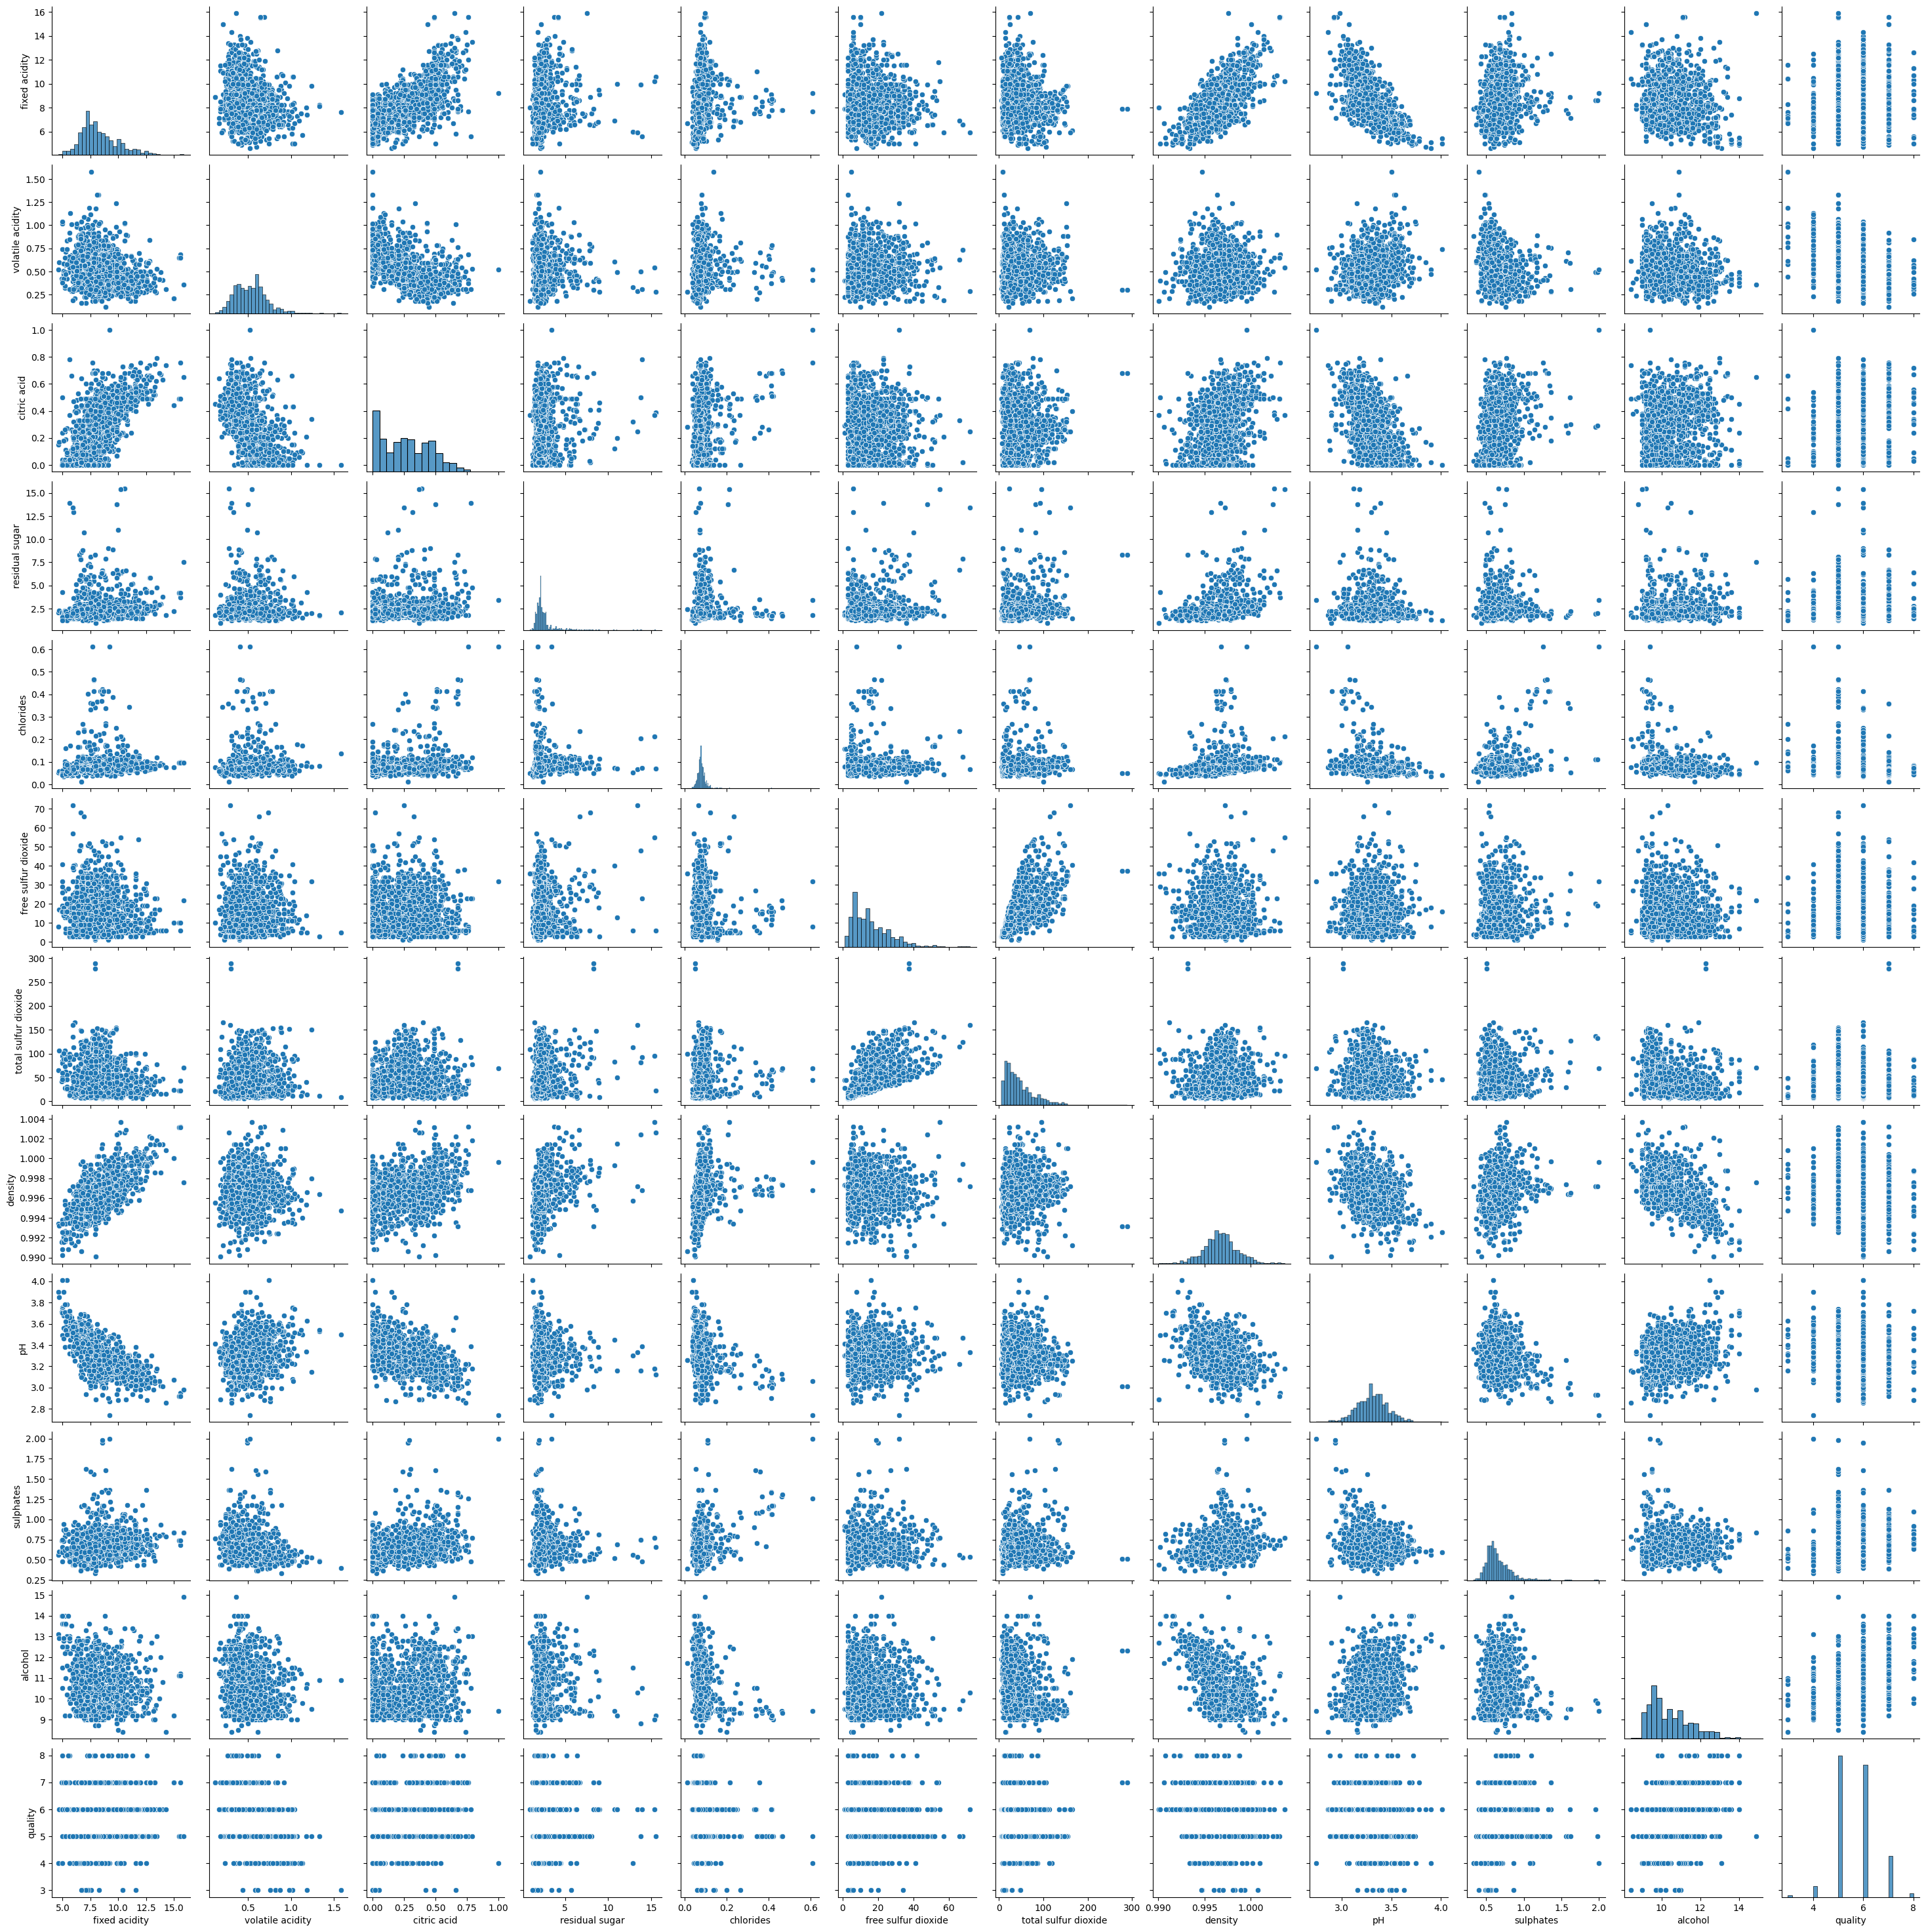

In [22]:
# Plot a scatterplot of all the variable
sns.pairplot(wine_df)

The chosen analysis involves comparing a numerical variable with a categorical variable. Since most statistical models require numerical inputs, it is necessary to transform the categorical data into a suitable format. To accomplish this, we apply **one-hot encoding** to the `quality` column, which converts each category into a separate binary feature, allowing the model to process the categorical information effectively.


In [23]:
# Use pandas.get_dummies to convert the quality column into dummy variables
wine_df_dummies = pd.get_dummies(
    wine_df, columns=["quality"], drop_first=False, dtype=int
)
wine_df_dummies.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality_3  quality_4  quality_5  quality_6  quality_7  quality_8  
0      9.4          0          0          1          0          0          0  
1      9.8          0          0          1          0          0          0  
2      9.8          0          0          1          0          0          0  
3      9.8          0          0          0          1          0          0  
4      9.4          0          0          1          0          0          0

The features considered in this analysis are **volatile acidity**, **sulphates**, **total sulfur dioxide**, **density**, **pH**, and **alcohol**. Although it is evident that **alcohol** and **density** are correlated with other variables, they are included in the study for completeness. Any necessary adjustments will be applied during the testing phase to account for these relationships.


In [ ]:
# Drop rows with NaN values in specific columns
var = [
    "volatile acidity",
    "sulphates",
    "total sulfur dioxide",
    "density",
    "pH",
    "alcohol",
]
for variable in var:
    wine_df_dummies[variable].dropna(inplace=True)

## Data Analysis

### Study of the Outliers

Outliers can have a significant impact on the performance and interpretation of a regression model, potentially distorting the estimated relationships between variables. For this reason, it is crucial to **identify and handle outliers prior to modeling**.

Given that several feature distributions are **slightly skewed**, we apply a **robust statistical method**—the **Interquartile Range (IQR)**—to detect outliers. The IQR is defined as:


$\text{IQR} = Q_3 - Q_1$


Where $Q_1$ and $Q_3$ are the first and third quartiles, respectively. A data point is considered an **outlier** if it falls outside the following range:

$x < Q_1 - 1.5 \times \text{IQR} \quad \text{or} \quad x > Q_3 + 1.5 \times \text{IQR}$

This method is particularly effective when dealing with non-normally distributed data, as it relies on percentile-based thresholds rather than assumptions about the mean and standard deviation.


In [ ]:
outliers_ = {}

for variable in var:
    Q1_ = Q1[variable]
    Q3_ = Q3[variable]
    IQR_ = IQR[variable]
    lower_bound_ = lower_bound[variable]
    higher_bound_ = higher_bound[variable]
    outliers_[variable] = wine_df_dummies.loc[
        (wine_df_dummies[variable] < lower_bound_)
        | (wine_df_dummies[variable] > higher_bound_),
        variable,
    ]

# Build a table where for each variable we have the number of outliers and the minimum of the higher bound

outliers_summary = pd.DataFrame(
    {
        "variable": var,
        "num_outliers": [len(outliers_[v]) for v in var],
        "outliers_percentage": [
            len(outliers_[v]) / len(wine_df_dummies) * 100 for v in var
        ],
        "min_higher_bound": [outliers_[v].min() for v in var],
        "max_higher_bound": [outliers_[v].max() for v in var],
    }
)

print(outliers_summary)

               variable  num_outliers  outliers_percentage  min_higher_bound  \
0      volatile acidity            19             1.188243          1.020000   
1             sulphates            59             3.689806          1.000000   
2  total sulfur dioxide            55             3.439650        124.000000   
3               density            45             2.814259          0.990070   
4                    pH            35             2.188868          2.740000   
5               alcohol            13             0.813008         13.566667   

   max_higher_bound  
0           1.58000  
1           2.00000  
2         289.00000  
3           1.00369  
4           4.01000  
5          14.90000  


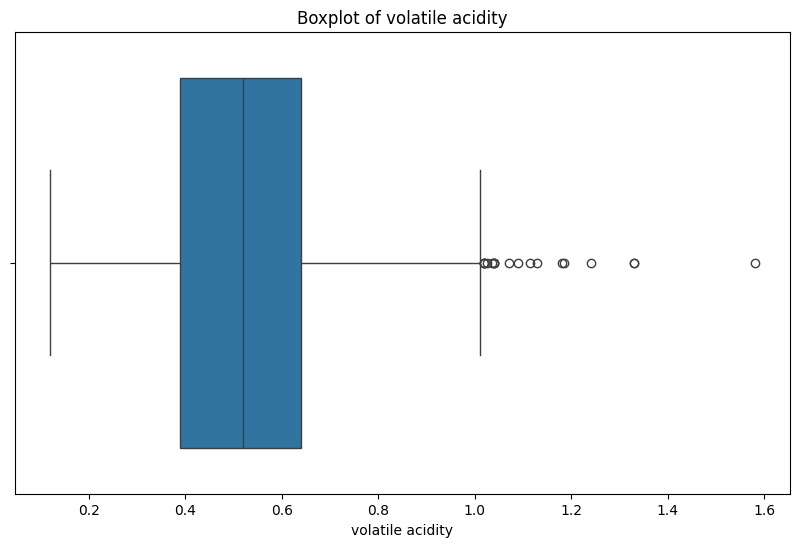

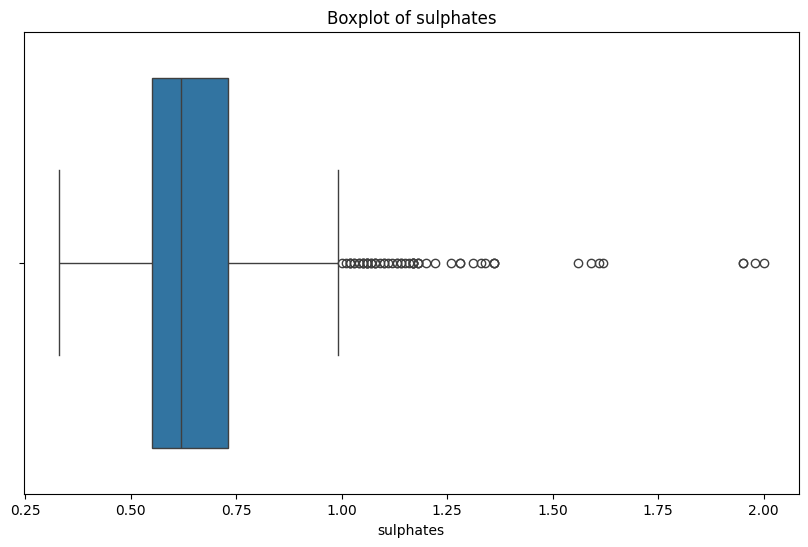

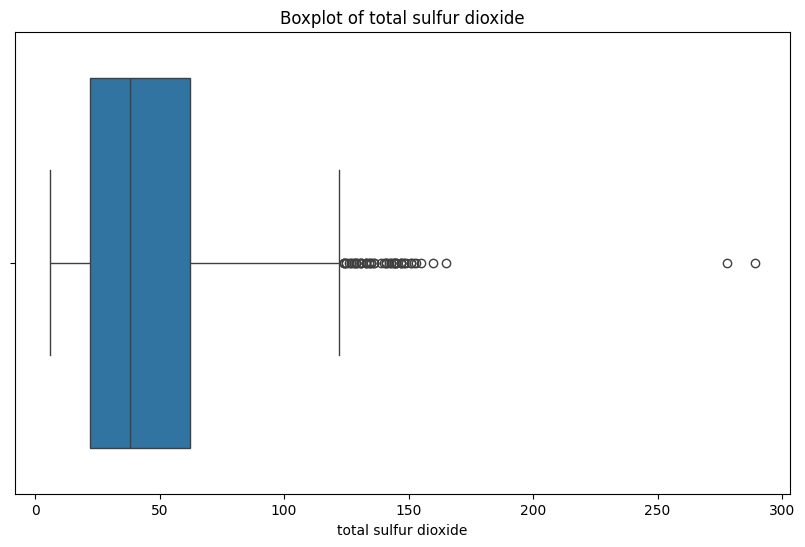

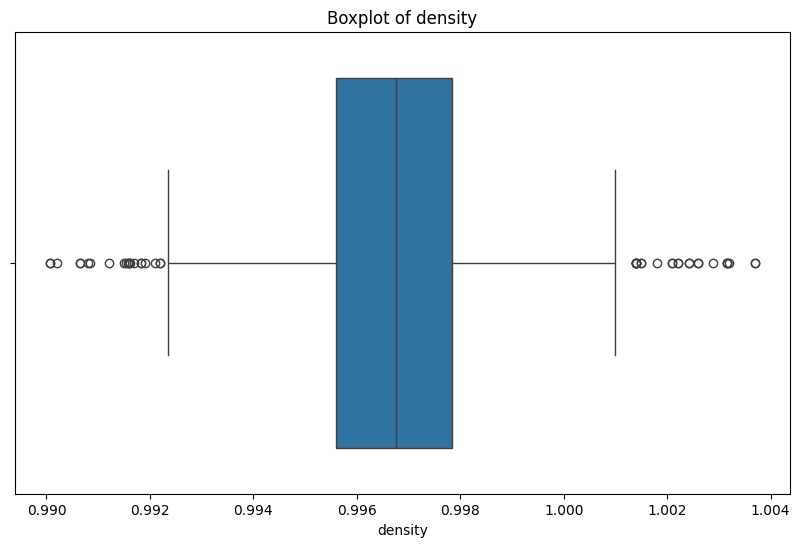

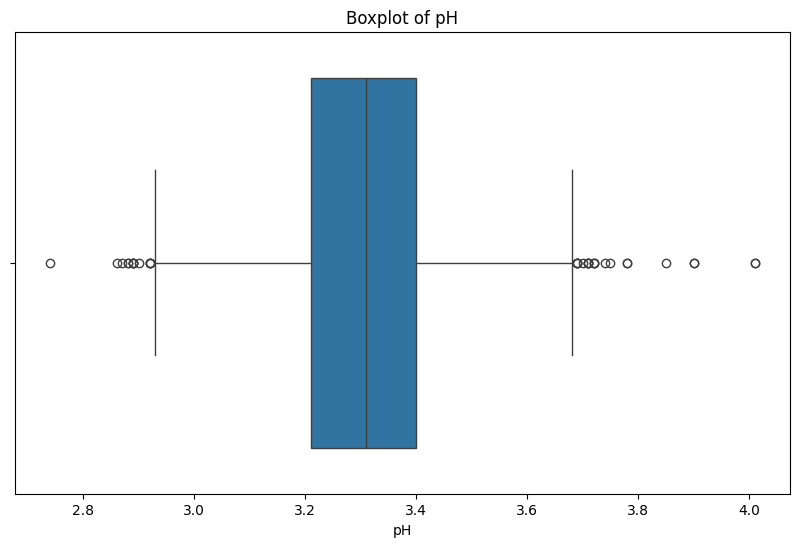

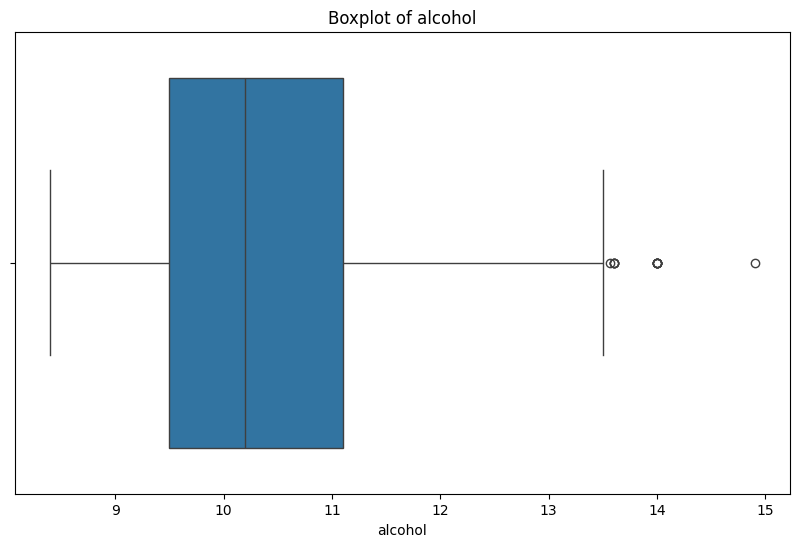

In [ ]:
variables = [
    "volatile acidity",
    "sulphates",
    "total sulfur dioxide",
    "density",
    "pH",
    "alcohol",
]
for var in variables:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=var, data=wine_df_dummies)
    plt.title(f"Boxplot of {var}")

We notice that the percentage of outliers is pretty small for the volatile acidite, but slighlty more significant for the remaining two variables. It is possible to make some conclusions with regards to the wines selction for the Pinto Verde:
- The volatile acidity remains low if compared to the usual range, and also the outliers do not reach any value above that. w
We can assume that this type of wine maintains a gentle fragance
- Regardin the sulphates, we notice that around the 3% has a level that could be considered rather high with possible effect on the flavour perceived
- The total sulfur dioxide remains within the legal limit and also the outliers remains pretty low, assuming so that none of the sample taken will provoke any headache
- Density and pH are quite balanced, reflecting somehow also their relationship
- The Alchol shows a consistent presence between up to 11 °, with some remaining types for bigger values

### Analysis of Quality Distribution and Sample Ratio Mismatch

For the categorical variable, the analysis focuses on **wine quality**. Specifically, we investigate whether any of the selected features have an effect on a particular quality level.

To support this analysis, the **distribution of quality levels** is printed and examined. This allows us to quantify any imbalance in the number of samples across quality categories, which is important for ensuring the reliability of classification models.


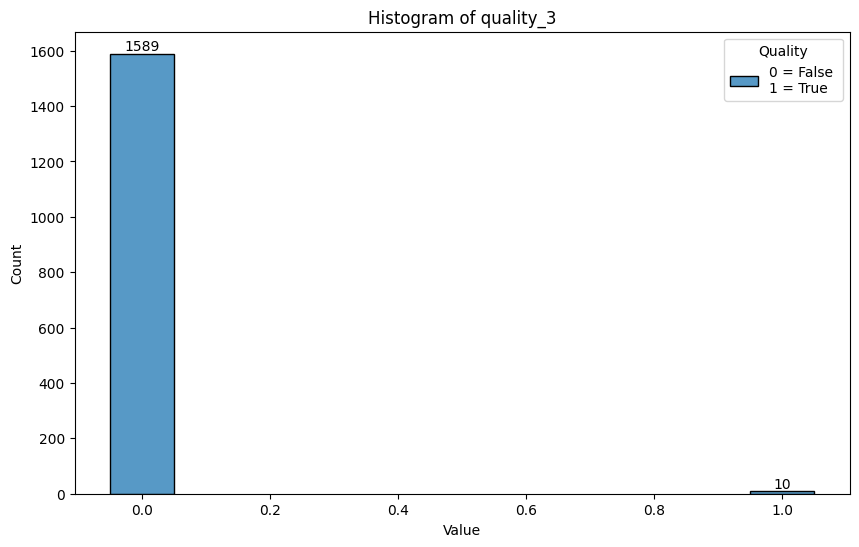

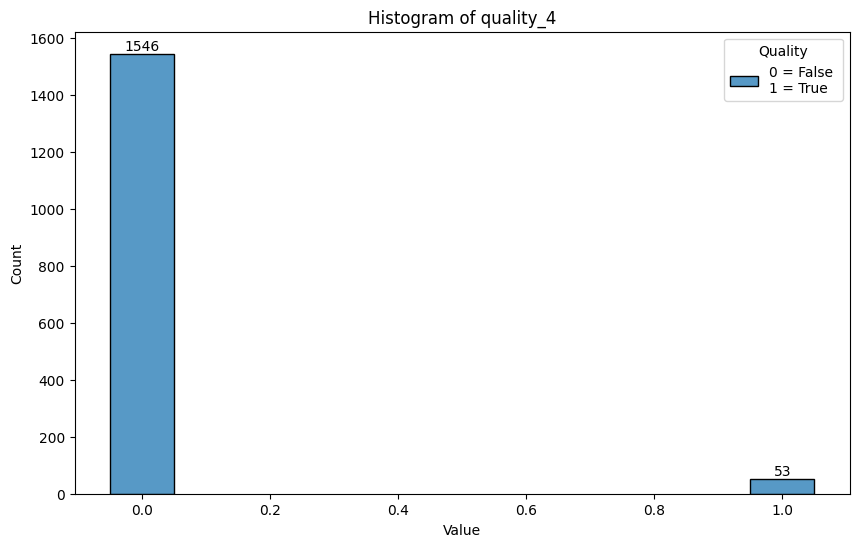

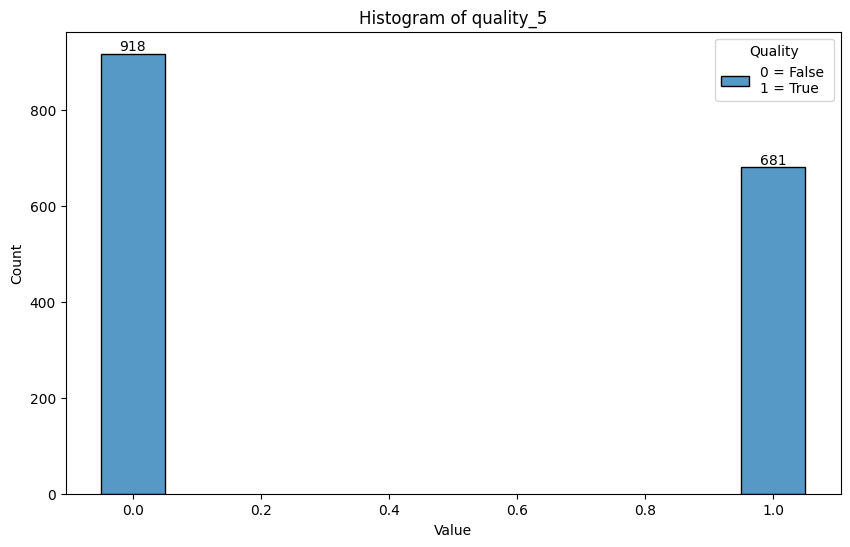

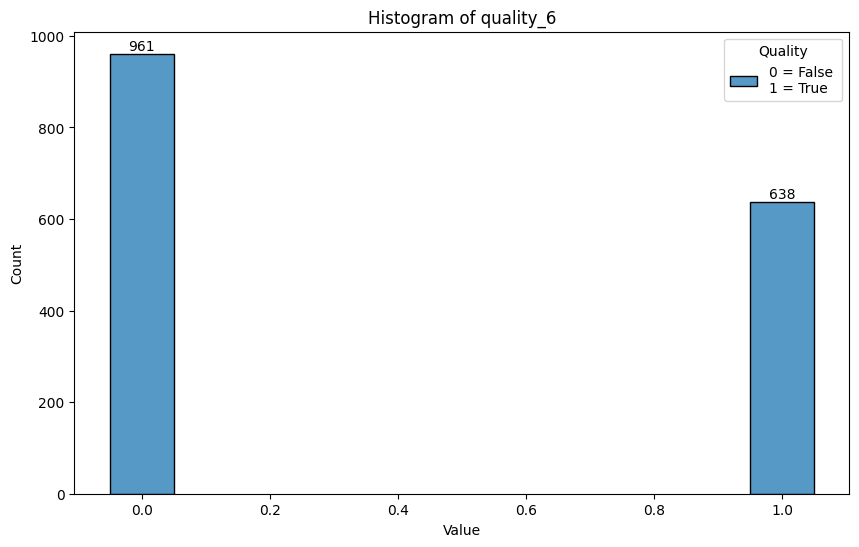

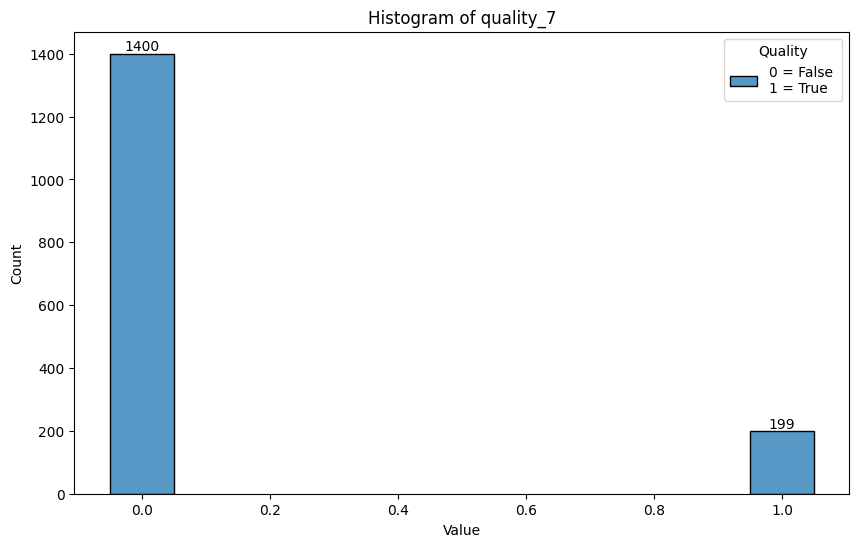

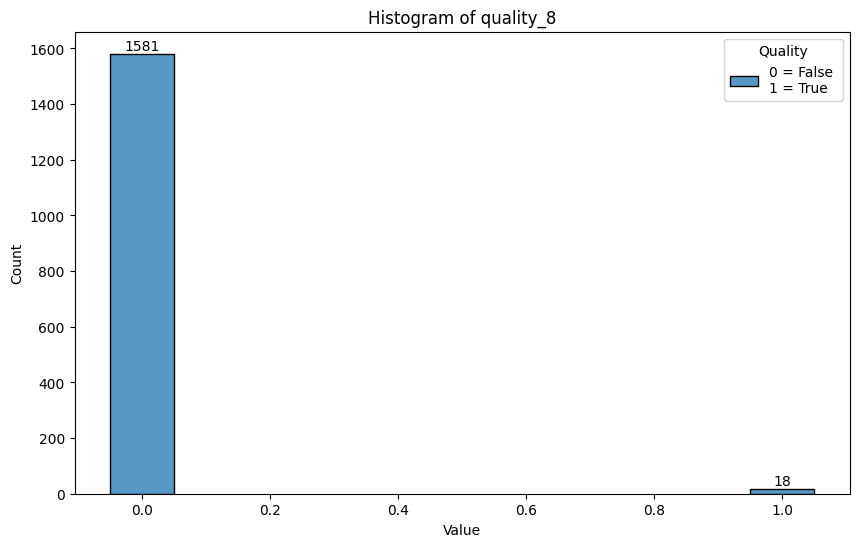

In [27]:
for i in range(3, 9):
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(wine_df_dummies[f"quality_{i}"], discrete=True, shrink=0.1)

    # Loop through all bars (patches) and annotate their height
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{int(height)}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="bottom",
            fontsize=10,
            color="black",
        )

    plt.title(f"Histogram of quality_{i}")
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.legend(title="Quality", labels=["0 = False \n1 = True"])
    plt.show()



To begin the categorical analysis, we focus on the **`quality`** variable, specifically whether certain features influence a wine's likelihood of being rated as quality level **6**. We first examine the distribution of quality scores to identify any **sample ratio mismatch**—a situation where one category has significantly more observations than another. This imbalance can affect the performance and fairness of classification models.

In this dataset, we observe that most wines are rated either **5** or **6**, with relatively fewer samples in other categories. Based on this observation, we limit our hypothesis to these two quality levels. Our goal is to determine whether the concentrations of **sulphates**, **total sulfur dioxide**, and **volatile acidity** have a **negative effect** on wine quality.

To explore this, we divide the dataset into two groups: wines of quality level 6 (**positive class**) and all others (**negative class**). For each feature, we categorize the values as **high** or **low**, based on their distribution or threshold (e.g., median or mean). This allows us to compare two categorical variables:
- **Wine quality** (yes = 6, no ≠ 6)
- **Feature level** (high or low)

We then assess whether higher concentrations of these chemical components are more frequently associated with lower quality wines. If the average values for these features are higher in the "not quality 6" group, we can argue that they may negatively affect wine quality.

Additionally, a **goodness-of-fit test** (e.g., chi-squared) may be used to evaluate whether the observed relationship between feature levels and quality categories can be generalized to a broader population.


In [28]:
wine_df_dummies.to_sql("Wine", conn, if_exists="replace", index=False)

1599

In [29]:
query = """
SELECT 
    quality_3,
    quality_4,
	quality_5,
	quality_6,
    quality_7,
    quality_8,
	CASE WHEN sulphates BETWEEN 0.3 AND 0.75 THEN 'medium-low' ELSE 'high' END AS sulphates_level,
	CASE WHEN [total sulfur dioxide] BETWEEN 10 AND 75 THEN 'medium-low' ELSE 'high' END AS total_sulfur_dioxide_level,
	CASE WHEN [volatile acidity] BETWEEN 0.1 AND 0.75 THEN 'medium-low' ELSE 'high' END AS volatile_acidity_level
FROM Wine;
"""

result = pd.read_sql_query(query, conn)
print(result)

      quality_3  quality_4  quality_5  quality_6  quality_7  quality_8  \
0             0          0          1          0          0          0   
1             0          0          1          0          0          0   
2             0          0          1          0          0          0   
3             0          0          0          1          0          0   
4             0          0          1          0          0          0   
...         ...        ...        ...        ...        ...        ...   
1594          0          0          1          0          0          0   
1595          0          0          0          1          0          0   
1596          0          0          0          1          0          0   
1597          0          0          1          0          0          0   
1598          0          0          0          1          0          0   

     sulphates_level total_sulfur_dioxide_level volatile_acidity_level  
0         medium-low                 m

In [30]:
result["sulphates_level"].value_counts()

sulphates_level
medium-low    1259
high           340
Name: count, dtype: int64

In [31]:
expected_sample = [799, 800]
observed_sample = result["sulphates_level"].value_counts().values
expected_sample = np.array(expected_sample)
chi2_stat, p_value = stats.chisquare(observed_sample, expected_sample)
print(f"Chi-squared statistics:{chi2_stat}, p-value: {p_value}")

Chi-squared statistics:529.3310387984982, p-value: 3.9489818361778744e-117


In [32]:
result["total_sulfur_dioxide_level"].value_counts()

total_sulfur_dioxide_level
medium-low    1290
high           309
Name: count, dtype: int64

In [33]:
expected_sample = [799, 800]
observed_sample = result["total_sulfur_dioxide_level"].value_counts().values
expected_sample = np.array(expected_sample)
chi2_stat, p_value = stats.chisquare(observed_sample, expected_sample)
print(f"Chi-squared statistics:{chi2_stat}, p-value: {p_value}")

Chi-squared statistics:603.0796605131414, p-value: 3.580562009155343e-133


We observed that, in all three cases, the **p-values** are significantly smaller than the conventional threshold of 0.05. This indicates that the differences between groups are statistically significant, confirming the presence of a **substantial sample ratio mismatch (SRM)**.

Additionally, the **chi-squared statistic values** are notably high. Since the chi-squared test measures the degree to which the **observed frequencies deviate from the expected frequencies** under the null hypothesis, a large statistic reinforces the conclusion that the distributions across groups are not due to random chance. In this context, it provides further evidence that the sample groups (e.g., wines with different quality ratings or feature levels) are **unevenly distributed**, which may impact the fairness or accuracy of subsequent analyses.


### Quality distribution

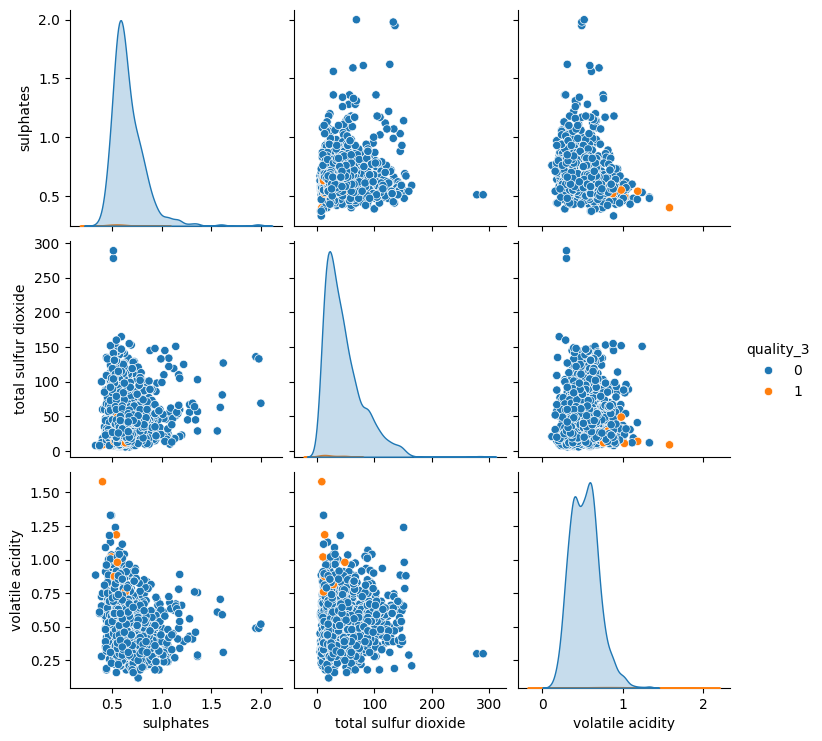

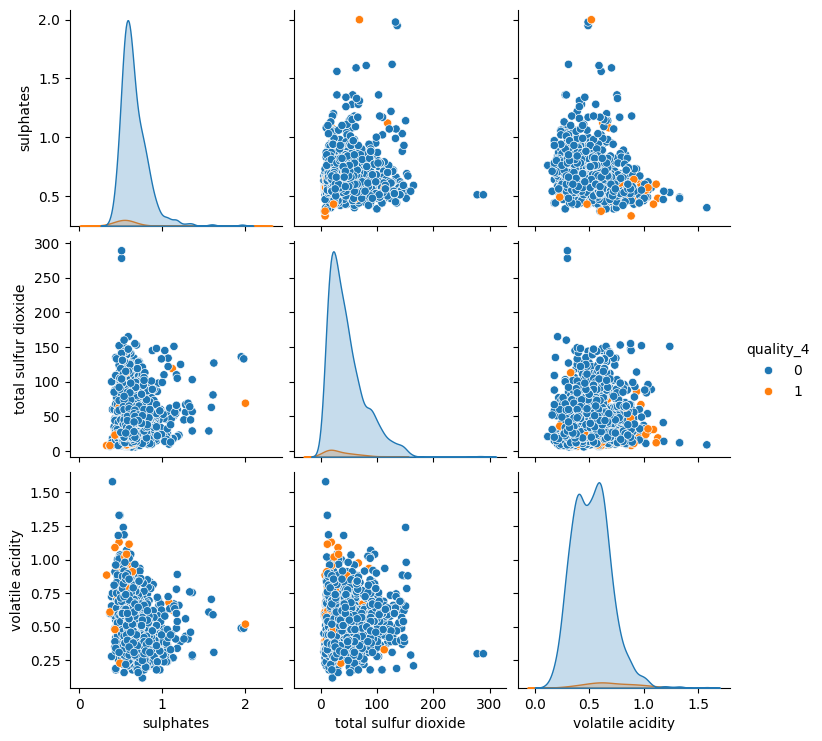

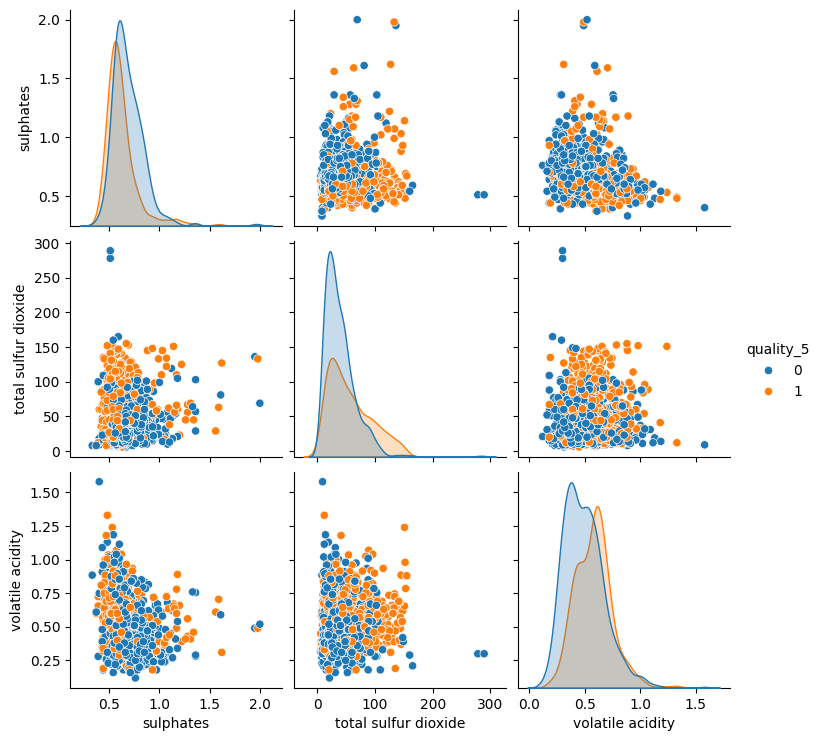

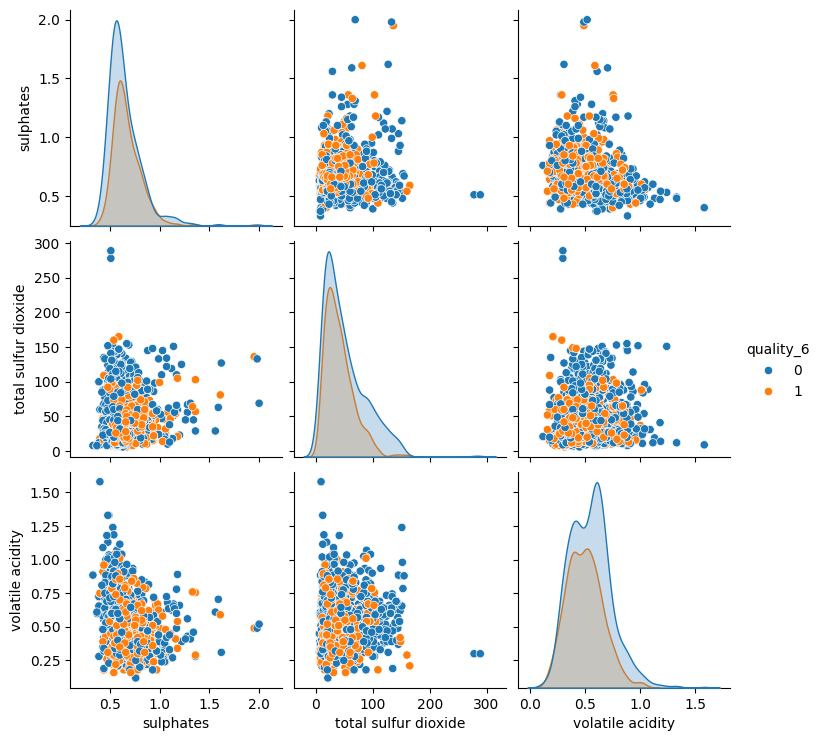

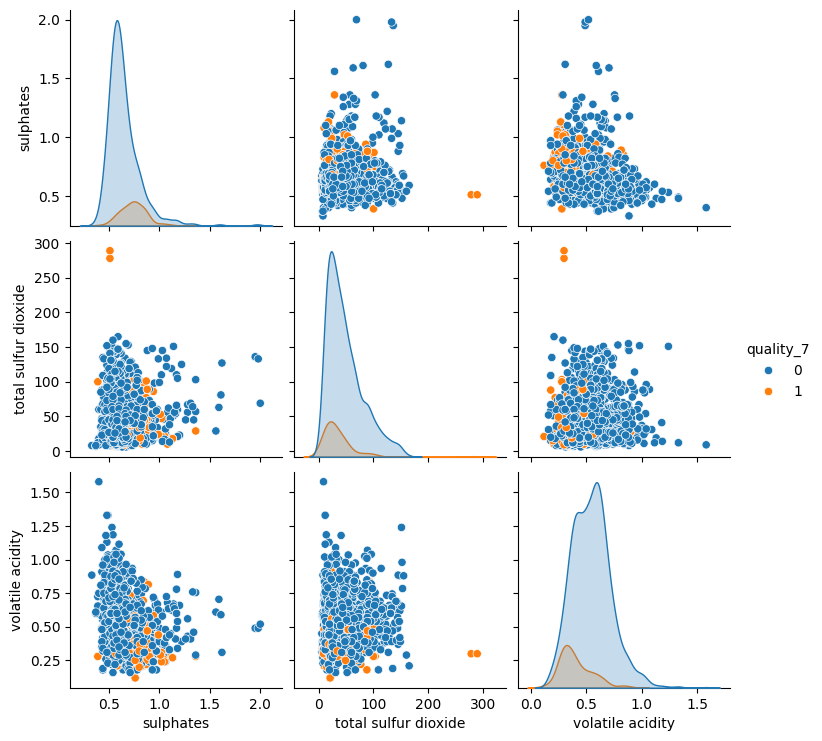

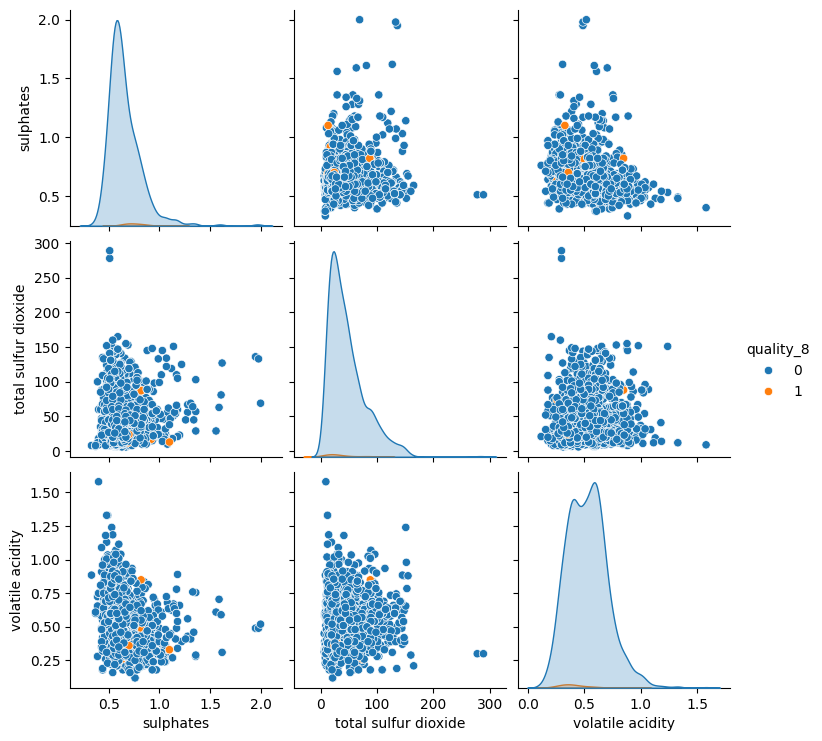

In [34]:
# Plot the scatterplot between with the encoded quality
for i in range(3, 9):
    sns.pairplot(
        wine_df_dummies,
        vars=["sulphates", "total sulfur dioxide", "volatile acidity"],
        hue=f"quality_{i}",
    )

During the exploratory data analysis, it was observed that several features exhibited **skewed distributions**, deviating from normality. To address this issue and improve the performance and interpretability of the statistical models, a **logarithmic transformation** was applied to the skewed variables. This transformation helps to stabilize variance, reduce the impact of outliers, and bring the feature distributions closer to a normal shape, which is often an underlying assumption in linear modeling.


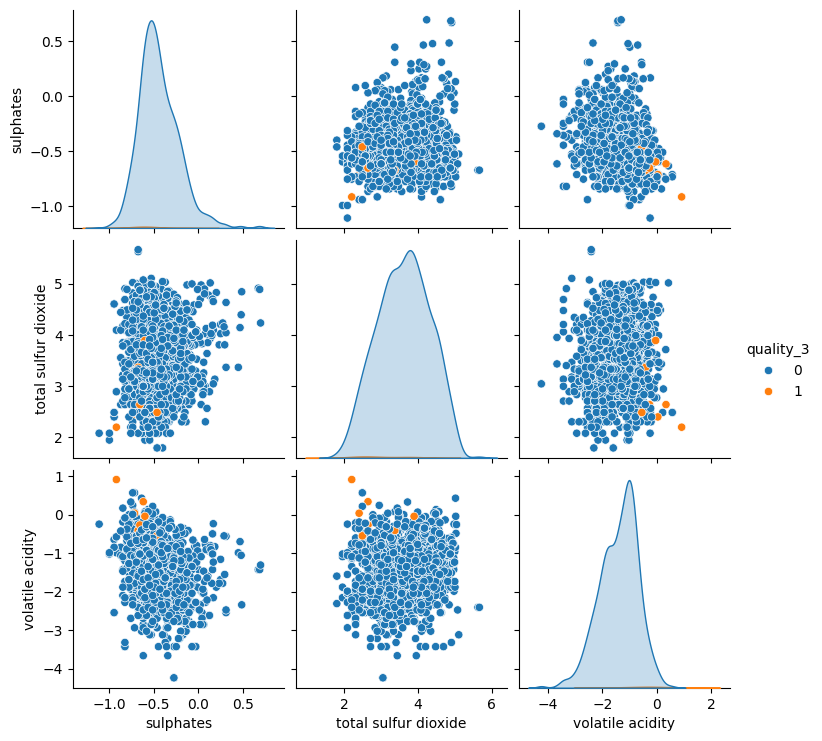

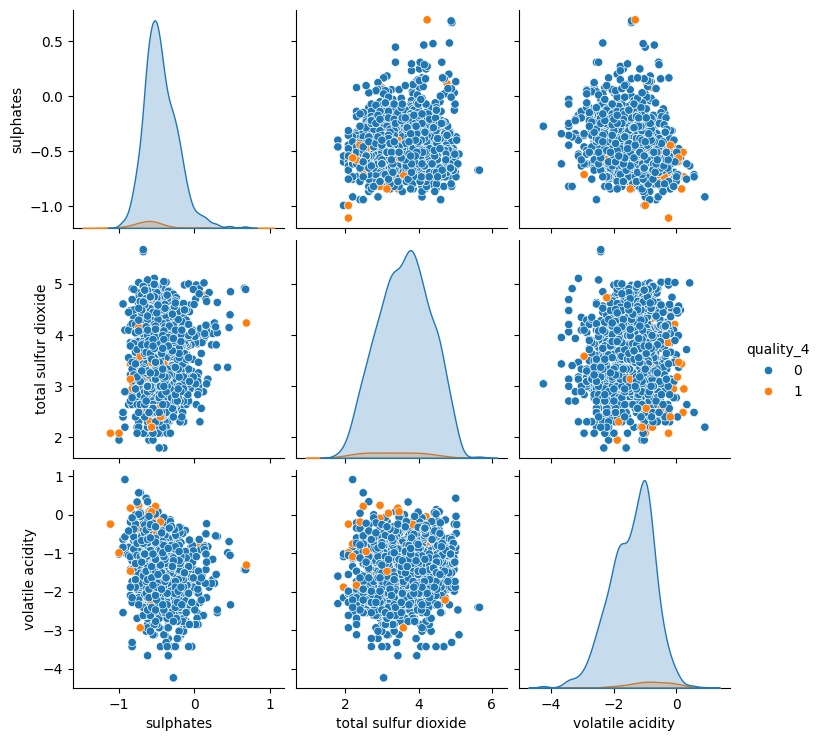

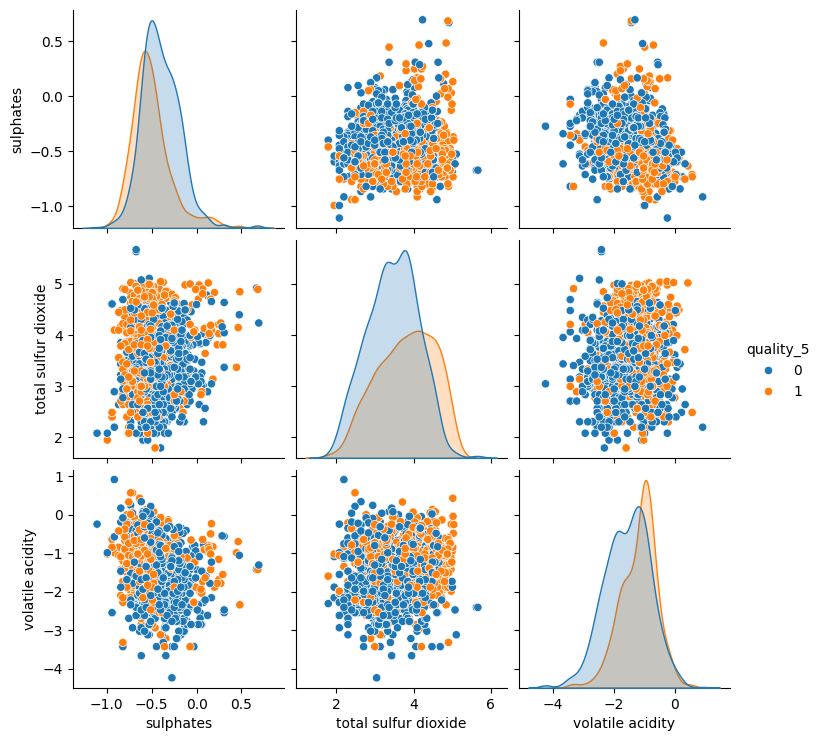

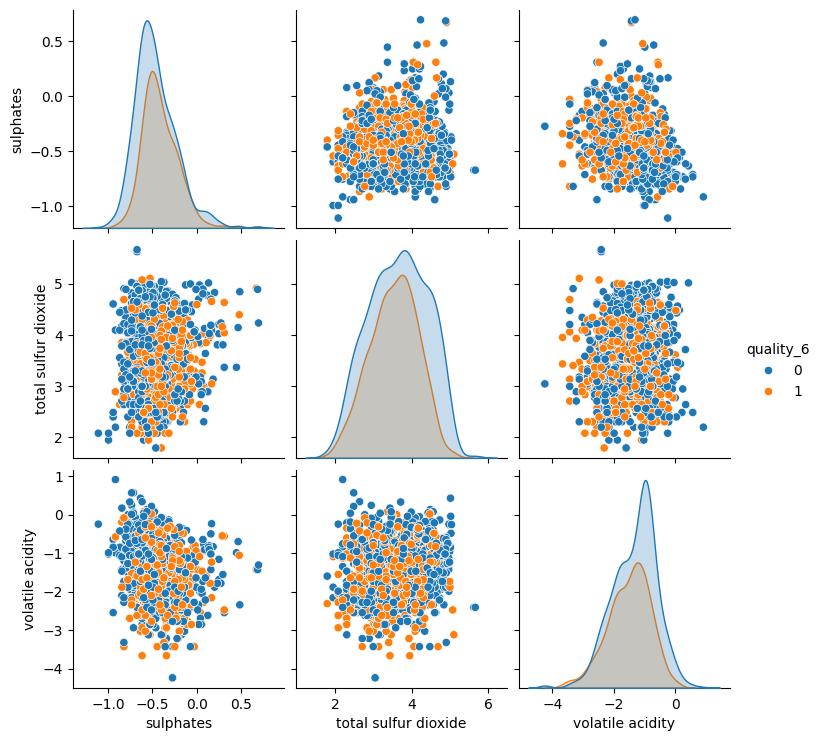

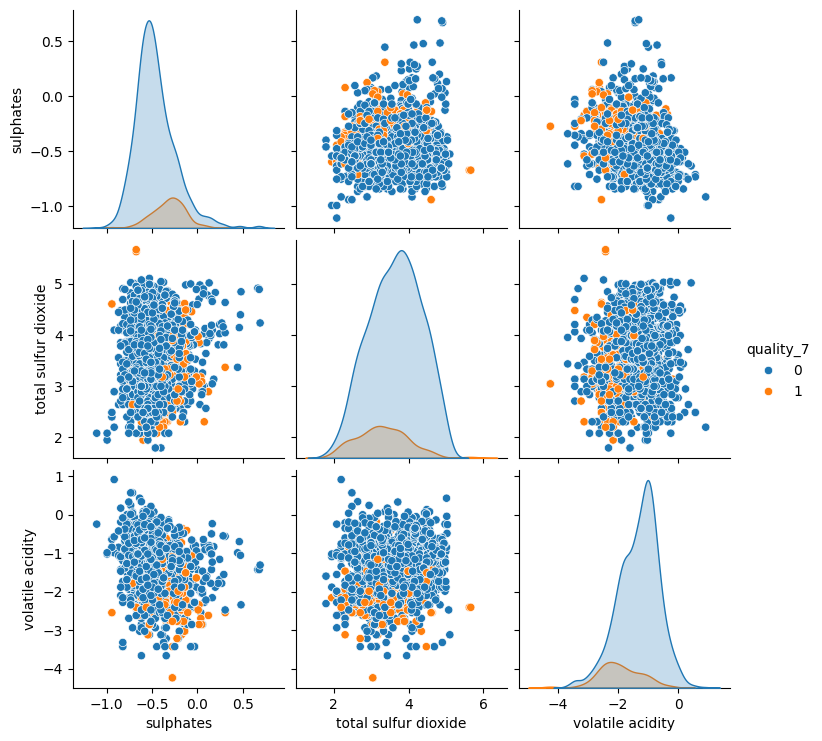

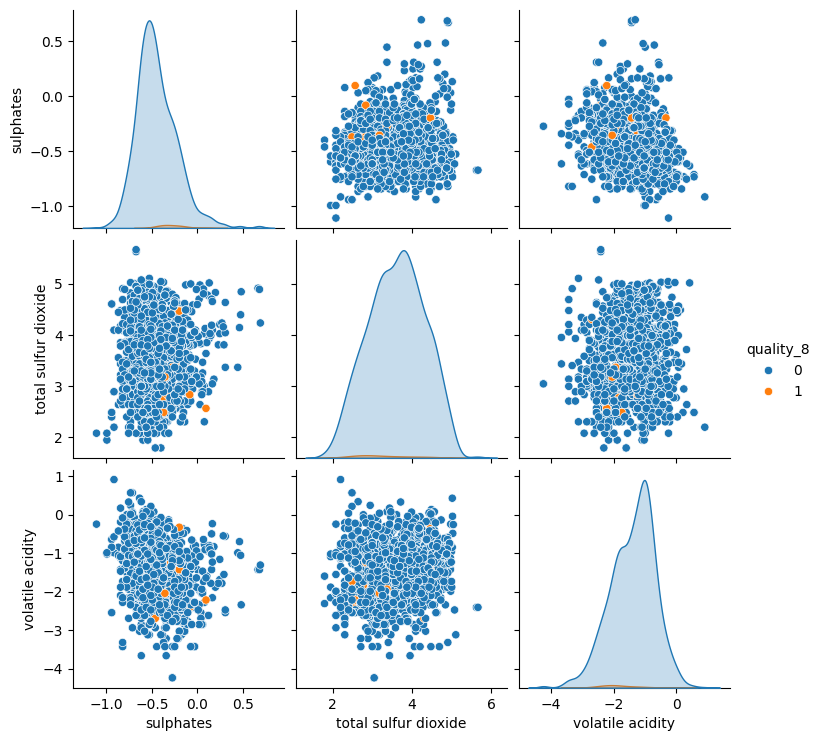

In [ ]:
wine_df_dummies["volatile acidity"] = wine_df_dummies["volatile acidity"] ** 2
wine_log = np.log(
    wine_df_dummies[
        [
            "sulphates",
            "total sulfur dioxide",
            "volatile acidity",
            "density",
            "pH",
            "alcohol",
        ]
    ]
)
for i in range(3, 9):
    wine_log[f"quality_{i}"] = wine_df_dummies[f"quality_{i}"]
    sns.pairplot(
        wine_log,
        vars=["sulphates", "total sulfur dioxide", "volatile acidity"],
        hue=f"quality_{i}",
    )

The trasformation helped to reduce the skewedness, but stil we do not have a perfect normal distribution of the independent variables, hence this will lead to choice non-categorical test.

### Logistic Model Fit

We now proceed by building the **Logistic Regression model** using **80% of the dataset** for training. This training subset will be used to fit the model parameters, while the remaining 20% will be reserved for evaluating the model’s performance on unseen data.

The logistic function for multivariable regression is  $$ P(\mathbf{x}) = \frac{e^{(\beta_0 + \beta_1 X + \cdots + \beta_n x_n)}}{1 + e^{(\beta_0 + \beta_1 X + \cdots + \beta_n x_n)}} $$
and after few transformations we can define the  odds as $$ \frac{P(\mathbf{x})}{1 - P(\mathbf{x})} = e^{(\beta_0 + \beta_1 X + \cdots + \beta_n x_n)} $$
whose result can take any value between odds 0 and infinite that respectively represent a  very low or very high probabilities of default.

By calculating the logarithm of both sides  $$ log(\frac{P(\mathbf{x})}{1 - P(\mathbf{x})}) = \beta_0 + \beta_1 X + \cdots + \beta_n x_n $$

We see that the logistic log odds logit regression model has a logit that is linear in X. The amount that p(X) changes due to a one-unit change in
X depends on the current value of X. But regardless of the value of X, if #1 is positive then increasing X will be associated with increasing p(X), and if #1 is negative then increasing X will be associated with decreasing p(X).

In [ ]:
# Let's try the logistic regression model

X_wine = wine_log[["sulphates", "total sulfur dioxide", "volatile acidity"]].copy()
X_wine["sulphates_x_total_sulfur_dioxide"] = (
    X_wine["sulphates"] * X_wine["total sulfur dioxide"]
) ** 2
X_wine["sulphates_x_volatile_acidity"] = (
    X_wine["sulphates"] * X_wine["volatile acidity"]
) ** 2
X_wine["total_sulfur_dioxide_x_volatile_acidity"] = (
    X_wine["total sulfur dioxide"] * X_wine["volatile acidity"]
) ** 2
scaler = StandardScaler()
X_wine_scaled = scaler.fit_transform(X_wine)
y_wine = wine_log["quality_6"]  # binary: 1 if quality == 6, else 0

# Add constant term
X_wine_const = sm.add_constant(X_wine_scaled)

# Fit logistic regression
logit_model = sm.Logit(y_wine, X_wine_const)
logit_results = logit_model.fit()

print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.651906
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              quality_6   No. Observations:                 1599
Model:                          Logit   Df Residuals:                     1592
Method:                           MLE   Df Model:                            6
Date:                Sun, 17 Aug 2025   Pseudo R-squ.:                 0.03077
Time:                        07:23:19   Log-Likelihood:                -1042.4
converged:                       True   LL-Null:                       -1075.5
Covariance Type:            nonrobust   LLR p-value:                 2.462e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4348      0.053     -8.268      0.000      -0.538      -0.332
x1            -0.0475      0.

<Axes: >

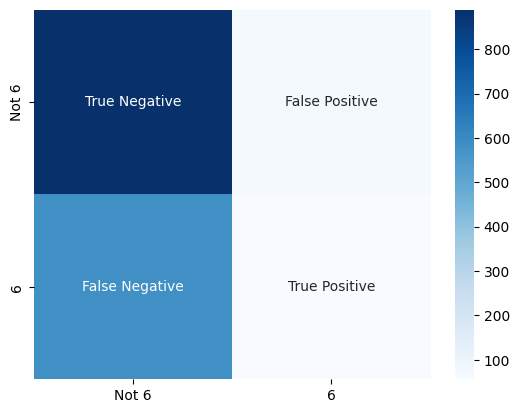

In [ ]:
# print of the confusion matrix
conf_matrix = confusion_matrix(y_wine, logit_results.predict(X_wine_const) > 0.5)
labels = ["True Negative", "False Positive", "False Negative", "True Positive"]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(
    conf_matrix,
    annot=labels,
    fmt="",
    cmap="Blues",
    xticklabels=["Not 6", "6"],
    yticklabels=["Not 6", "6"],
)

To evaluate the model, we taken into consideration the following features:

**- Precision**: measures the accurancy of the positive predictions - "among all the positive predicted values, how many are actually positive ?"

**- Recall (aka Sensitivity)**: measures the model's ability to find all the positive instances - "of all positives, how many did the model correctly identify ?"

**- F1 Score:** harmonic mean of precision and accurancy, it balances the two metrics into a single number

**- Accurancy** can be misleading, especially in the case when the two classes are unbalanced, the model can predict with a solid accurancy one of the classes, but completely fail to predict the other.


In [38]:
# Step 1: Get predicted probabilities for class 1 (quality_6 = 1)
y_pred_prob = logit_results.predict(X_wine_const)

# Step 2: Convert probabilities to binary predictions using threshold = 0.5
y_pred_class = (y_pred_prob >= 0.5).astype(int)

# Step 3: Calculate metrics
accuracy = accuracy_score(y_wine, y_pred_class)
precision = precision_score(y_wine, y_pred_class)
recall = recall_score(y_wine, y_pred_class)
f1 = f1_score(y_wine, y_pred_class)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.591
Precision: 0.438
Recall: 0.088
F1 Score: 0.146


The model demonstrates **modest accuracy (0.591)**, only slightly better than a naive guess based on class distribution. However, the **precision (0.438)** and especially the **recall (0.088)** are quite low, indicating that the model struggles to correctly identify positive cases. This imbalance suggests that the model may be biased toward the majority class, failing to detect true positives effectively. The **F1 score (0.146)**, which balances precision and recall, further reflects the poor performance in capturing the minority class. This indicates a need for further improvements, such as handling class imbalance or using more complex models.


As improvement, we try to use interaction and weighted classes.

In [ ]:
# Add more variables to the model
# Let's try the logistic regression model

X_wine = wine_df_dummies[["alcohol", "density", "citric acid"]].copy()
X_wine["alcohol_x_density"] = (X_wine["alcohol"] * X_wine["density"]) ** 2
X_wine["alcohol_x_citric_acid"] = (X_wine["alcohol"] * X_wine["citric acid"]) ** 2
X_wine["density_x_citric_acid"] = (X_wine["density"] * X_wine["citric acid"]) ** 2
X_wine = X_wine  # transform the features
scaler = StandardScaler()
X_wine_scaled = scaler.fit_transform(X_wine)
y_wine = wine_log["quality_6"]  # binary: 1 if quality == 6, else 0

# Add constant term
X_wine_const = sm.add_constant(X_wine_scaled)

# Calculate class counts
class_counts = y_wine.value_counts()
w_0 = 1 / class_counts[0]  # weight for class 0
w_1 = 1 / class_counts[1]  # weight for class 1

weights = y_wine.map({0: w_0, 1: w_1})

# Fit logistic regression
logit_model = sm.Logit(y_wine, X_wine_const, freq_weights=weights)
logit_results = logit_model.fit()

print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.652027
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              quality_6   No. Observations:                 1599
Model:                          Logit   Df Residuals:                     1592
Method:                           MLE   Df Model:                            6
Date:                Sun, 17 Aug 2025   Pseudo R-squ.:                 0.03059
Time:                        07:23:19   Log-Likelihood:                -1042.6
converged:                       True   LL-Null:                       -1075.5
Covariance Type:            nonrobust   LLR p-value:                 2.954e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4297      0.052     -8.201      0.000      -0.532      -0.327
x1             4.4930      0.

c:\Users\pietr\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)
c:\Users\pietr\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)


In [40]:
# Step 1: Get predicted probabilities for class 1 (quality_6 = 1)
y_pred_prob = logit_results.predict(X_wine_const)

# Step 2: Convert probabilities to binary predictions using threshold = 0.5
y_pred_class = (y_pred_prob >= 0.4).astype(int)

# Step 3: Calculate metrics
accuracy = accuracy_score(y_wine, y_pred_class)
precision = precision_score(y_wine, y_pred_class)
recall = recall_score(y_wine, y_pred_class)
f1 = f1_score(y_wine, y_pred_class)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.604
Precision: 0.503
Recall: 0.652
F1 Score: 0.568


To improve the model's performance, we proceed by training a **Random Forest Classifier**. Unlike **Logistic Regression**, which is a linear model that assumes a linear relationship between the features and the log-odds of the target, **Random Forest** is a powerful **ensemble learning method** based on decision trees.

A Random Forest builds multiple decision trees during training and outputs the class that is the majority vote among all trees. This allows the model to capture **non-linear relationships** and complex feature interactions that logistic regression may miss. Additionally, Random Forest is more robust to outliers and does not require strict assumptions about the distribution of the features.

By using this more flexible model, we aim to improve recall and overall classification performance, particularly in the presence of class imbalance and non-linearity.


In [ ]:
# Try with Random Forest Classifier
X_wine = wine_log[["sulphates", "total sulfur dioxide", "volatile acidity"]]
y_wine = wine_log["quality_6"]  # binary: 1 if quality == 6, else 0
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_wine, y_wine, test_size=0.2, random_state=42
)
# Create the Random Forest Classifier model
rf = RandomForestClassifier(
    n_estimators=200, max_depth=None, random_state=42, class_weight="balanced"
)
rf.fit(X_train, y_train)
# Predict on the test set
y_predict = rf.predict(X_test)
# Calculate metrics
accurancy = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)
# Print results
print(f"Accurancy:{ accurancy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Accurancy:0.672
Precision: 0.636
Recall: 0.477
F1 Score: 0.545


### Linera Regression Model

For the linear regression analysis, we modeled **"volatile acidity"** as the target (dependent) variable. The selected **independent variables** were:

- `"sulphates"`
- `"total sulfur dioxide"`

The goal of this analysis was to investigate how these two chemical properties influence the level of volatile acidity in the wine. By applying a linear regression model, we aim to quantify the strength and direction of their relationships with the target variable.


In [ ]:
# Split data
train_wine = wine_log.sample(frac=0.8, replace=False, random_state=42)

# Define features and target
X = train_wine[["sulphates", "total sulfur dioxide"]]
y = train_wine["volatile acidity"]

# Add constant for intercept
X_const = sm.add_constant(X)

# Fit linear regression
wine_model_linear = sm.OLS(y, X_const).fit()

# Summarize model
print(wine_model_linear.summary())

# Predict
y_pred = wine_model_linear.predict(X_const)

# Evaluate
r2 = r2_score(y, y_pred)
print("R² Score:", r2)

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y, y_pred)
print("Mean Absolute Error:", mae)

                            OLS Regression Results                            
Dep. Variable:       volatile acidity   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     71.28
Date:                Sun, 17 Aug 2025   Prob (F-statistic):           4.52e-30
Time:                        07:23:21   Log-Likelihood:                -1311.2
No. Observations:                1279   AIC:                             2628.
Df Residuals:                    1276   BIC:                             2644.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.2122 

c:\Users\pietr\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


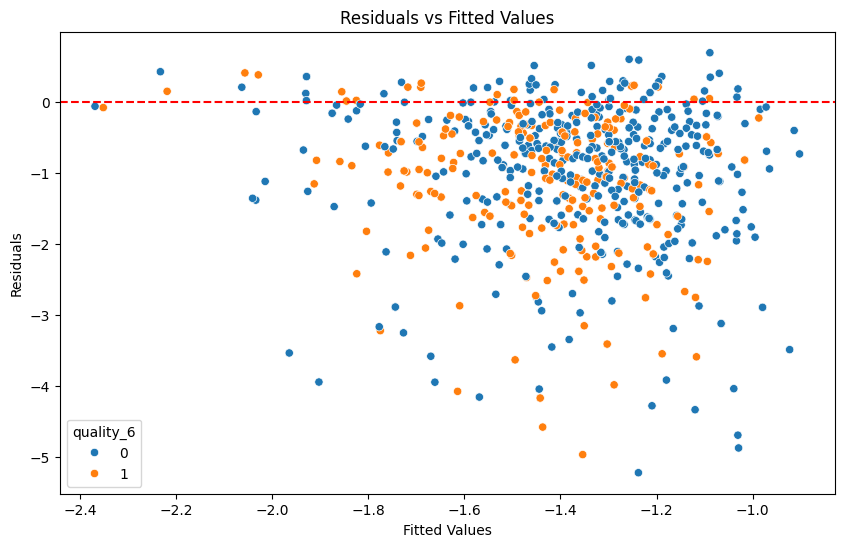

In [ ]:
# Residual study
rsd_wine = np.log(wine_model_linear.resid)
fit_wine = wine_model_linear.fittedvalues
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fit_wine, y=rsd_wine, hue=wine_log["quality_6"])
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

The linear regression model shows a **modest fit** to the data:

- **R² Score:** 0.100 — only about 10% of the variance in volatile acidity is explained by the model.  
- **Mean Squared Error (MSE):** 0.455 — on average, the squared deviation between predicted and actual values is moderate.  
- **Mean Absolute Error (MAE):** 0.536 — on average, predictions deviate from actual values by about 0.536 units.

These results suggest that while there is some relationship between `"sulphates"` and `"total sulfur dioxide"` with volatile acidity, the linear model captures only a small portion of the variability.  

For further study, we later **extend the model** by including **polynomial interaction terms** and two additional variables, **pH** and **density**, to evaluate how these additional features and potential **multicollinearity** affect the model's performance and coefficient estimates.


In [ ]:
train_wine = wine_log.sample(frac=0.8, replace=False, random_state=42)

# Features and target
X = train_wine[["sulphates", "total sulfur dioxide", "pH", "density", "alcohol"]]
y = train_wine["volatile acidity"]

# Optional: Polynomial features with interactions
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Add constant
X_poly_const = sm.add_constant(X_poly)

# Fit model
model = sm.OLS(y, X_poly_const).fit()
print(model.summary())

# Predict
y_pred = model.predict(X_poly_const)

# Evaluate
print("R² Score:", r2_score(y, y_pred))
print("Mean Squared Error:", mean_squared_error(y, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y, y_pred))

                            OLS Regression Results                            
Dep. Variable:       volatile acidity   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     24.67
Date:                Sun, 17 Aug 2025   Prob (F-statistic):           2.19e-76
Time:                        07:23:21   Log-Likelihood:                -1167.3
No. Observations:                1279   AIC:                             2377.
Df Residuals:                    1258   BIC:                             2485.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.3404     17.688      3.129      0.0

After extending the linear regression model with **polynomial interaction terms** and adding **pH** and **density** as additional features, the model performance improved:

- **R² Score:** 0.282 — the model now explains roughly 28% of the variance in volatile acidity, a noticeable improvement over the previous 10%.  
- **Mean Squared Error (MSE):** 0.363 — the average squared prediction error decreased, indicating better fit.  
- **Mean Absolute Error (MAE):** 0.476 — on average, predictions are closer to the true values.

The inclusion of interaction terms and additional variables suggests that the relationships between the features and volatile acidity are **non-linear** and somewhat interdependent. However, the R² is still moderate, indicating that other factors not included in the model likely influence volatile acidity. This also highlights the potential effect of **multicollinearity**, which should be carefully assessed before interpreting coefficients.


To assess **multicollinearity** among the independent variables, we use the **Variance Inflation Factor (VIF)**. The VIF measures how much the variance of a regression coefficient \(\beta_j\) is inflated due to collinearity with other predictors in the model. Specifically, it is defined as the ratio of the variance of \(\beta_j\) in the full model to the variance of \(\beta_j\) when it is estimated in isolation.

As a rule of thumb, a **VIF greater than 5** (and especially above 10) is typically considered indicative of **high multicollinearity**, suggesting that the predictor is strongly correlated with other variables in the model and may undermine the reliability of the coefficient estimates.


In [ ]:
vals = [VIF(X, i) for i in range(0, X.shape[1])]
vif = pd.DataFrame({"VIF": vals}, index=X.columns[0:])
print(vif)

                             VIF
sulphates               5.494171
total sulfur dioxide   26.525947
pH                    466.273670
density                 4.436893
alcohol               421.236402


c:\Users\pietr\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


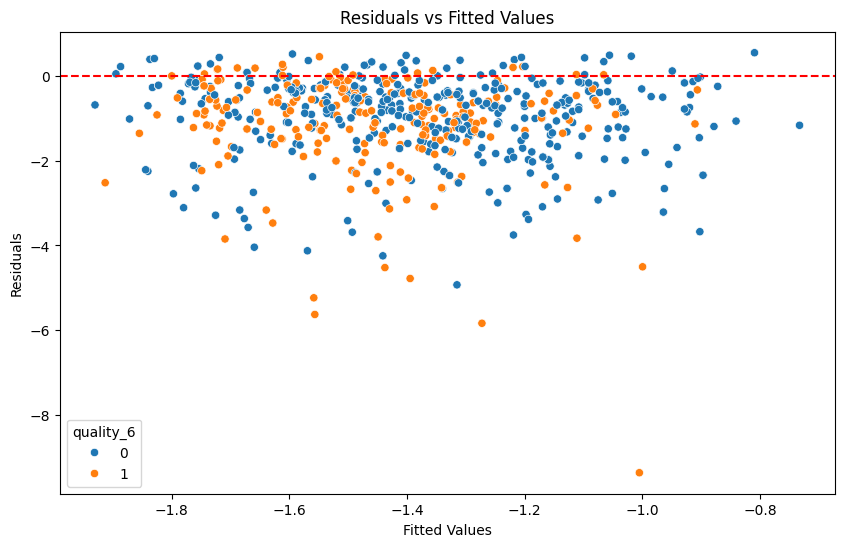

In [ ]:
# Residual study
rsd_wine = np.log(model.resid)
fit_wine = model.fittedvalues
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fit_wine, y=rsd_wine, hue=wine_log["quality_6"])
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

 sulphates            35             2.188868         -1.108663

> **Note:** For experimental purposes, we are also studying the model **without outliers**.  
> Removing outliers allows us to assess how extreme values affect the model's coefficients, fit, and overall performance. This can help understand the sensitivity of the regression results to unusual data points.


In [ ]:
# without ouliers

avg = wine_log["sulphates"].mean()
wine_log["sulphates"] = wine_log["sulphates"].where(
    wine_log["sulphates"] <= -1.108663, avg
)

train_wine = wine_log.sample(frac=0.8, replace=False, random_state=42)

# Features and target
X = train_wine[["sulphates", "total sulfur dioxide"]]
y = train_wine["volatile acidity"]

# Optional: Polynomial features with interactions
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Add constant
X_poly_const = sm.add_constant(X_poly)

# Fit model
model = sm.OLS(y, X_poly_const).fit()
print(model.summary())

# Predict
y_pred = model.predict(X_poly_const)

# Evaluate
print("R² Score:", r2_score(y, y_pred))
print("Mean Squared Error:", mean_squared_error(y, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y, y_pred))

                            OLS Regression Results                            
Dep. Variable:       volatile acidity   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     5.152
Date:                Sun, 17 Aug 2025   Prob (F-statistic):            0.00591
Time:                        07:23:22   Log-Likelihood:                -1373.8
No. Observations:                1279   AIC:                             2754.
Df Residuals:                    1276   BIC:                             2769.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9602      0.824      3.591      0.0

After removing outliers from the dataset, the linear regression model performance **dropped significantly**:

- **R² Score:** 0.008 — the model now explains less than 1% of the variance in volatile acidity, indicating almost no predictive power.  
- **Mean Squared Error (MSE):** 0.502 — the average squared error increased compared to the model with outliers.  
- **Mean Absolute Error (MAE):** 0.569 — predictions are on average farther from the actual values.

This outcome suggests that the removed outliers were contributing substantially to the linear relationship captured by the model. While outliers can distort models, in this case, they were also driving most of the apparent signal, highlighting the importance of carefully assessing which points to exclude.


c:\Users\pietr\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


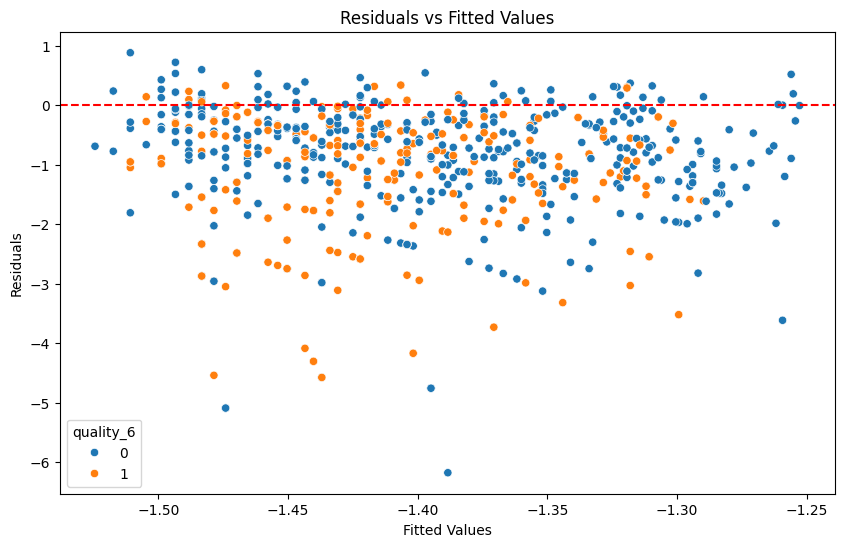

In [ ]:
# Residual study
rsd_wine = np.log(model.resid)
fit_wine = model.fittedvalues
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fit_wine, y=rsd_wine, hue=wine_log["quality_6"])
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

## Conclusions

- **Sample imbalance:**  
  During the analysis, we observed a significant mismatch in the sample sizes across different classes (e.g., wine quality levels). This imbalance makes it difficult to create balanced conditions for modeling. Models trained on limited or skewed data may produce biased predictions—for instance, a model trained mostly on medium-to-low acidity wines will likely perform poorly on high-acidity wines. Proper handling of class imbalance is crucial in both regression and classification tasks to ensure generalizable results.

- **Linear Regression:**  
  Despite its simplicity and interpretability, linear regression failed to produce statistically significant results for the chosen features. This is partly due to the high **collinearity** between variables such as sulphates, total sulfur dioxide, and volatile acidity. Collinearity inflates the variance of coefficient estimates, making it difficult to assess the true effect of each predictor and reducing the reliability of the model.

- **Logistic Regression vs. Random Forest:**  
  Logistic regression, even after applying transformations and class weighting to handle imbalance, provided only slightly better results than random guessing. This is expected when the signal in the features is weak or non-linear. On the other hand, the **Random Forest** classifier, a non-parametric ensemble method, captured complex interactions and non-linearities between features, leading to a noticeable improvement in predictive performance. Random Forest is more robust to multicollinearity and can naturally handle imbalanced or heterogeneous data, which explains the better outcome.
